In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from math import ceil

2023-10-04 17:50:03.190803: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 17:50:03.240368: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-04 17:50:04.347577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset

In [2]:
path = "GetData/Rust/get_data_rust/Data/FirstSet/"

In [3]:
def get_dataset(path):
    ''' Within the folder specified by the 'path' variable, data is organized into subfolders labeled as 'output[index].' 
    Each of these subfolders contains a final NumPy array and may also include an optional statistics dataframe.
    '''
    data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".npy"):
                data_file_path = os.path.join(root, file)
                data.append(np.load(data_file_path).flatten())

    return tf.convert_to_tensor(data, dtype=tf.float32)

In [4]:
dataset = get_dataset(path)
dataset.shape

2023-10-04 17:50:07.949315: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000 exceeds 10% of free system memory.


TensorShape([1000, 4096])

In [5]:
class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate=0.1):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate
        self.W = tf.Variable(tf.random.normal([num_visible, num_hidden], stddev=0.01))
        self.visible_bias = tf.Variable(tf.zeros([num_visible]))
        self.hidden_bias = tf.Variable(tf.zeros([num_hidden]))

    def sample_h_given_v(self, v):
        p_h_given_v = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hidden_bias)
        p = tf.random.uniform(shape = p_h_given_v.shape)
        h_new = tf.cast(p_h_given_v <= p, dtype=tf.float32)
        return h_new, p_h_given_v

    def sample_v_given_h(self, h):
        p_v_given_h = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.visible_bias)
        p = tf.random.uniform(shape = p_v_given_h.shape)
        v_new = tf.cast(p_v_given_h <= p, dtype=tf.float32)
        return v_new

    def train(self, input_data, num_epochs=10, batch_size=10):
        num_samples = input_data.shape[0]
        for epoch in range(num_epochs):
            total_loss = 0.0  # Track the total loss for this epoch
            for i in range(0, ceil(num_samples/batch_size), batch_size):
                v0 = input_data[i* batch_size:(i+1) * batch_size]
                h0, h0_prob = self.sample_h_given_v(v0)
                v_new = self.sample_v_given_h(h0)
                h_new, h_new_prob = self.sample_h_given_v(v0)
                reconstruction_loss = tf.reduce_mean(tf.square(v0 - v_new))
                total_loss += reconstruction_loss
                self.backward(v0, h0_prob, v_new, h_new_prob)

            if epoch % 5 == 0:
                avg_loss = total_loss / (num_samples / batch_size)
                print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        print("Training completed.")

    def backward(self, v0, h0_prob, v_new, h_new_prob):
        d_vb = np.average(v0, axis=0)-np.average(v_new, axis=0)
        d_hb = np.average(h0_prob, axis=0)-np.average(h_new_prob, axis=0)
        d_W = tf.matmul(tf.transpose(v0), h0_prob) - tf.matmul(tf.transpose(v_new), h_new_prob)
        self.W.assign_add(self.learning_rate * d_W)
        self.hidden_bias.assign_add(self.learning_rate * d_hb)
        self.visible_bias.assign_add(self.learning_rate * d_vb)

    def generate(self, num_samples):
        samples = tf.random.uniform(shape=[num_samples, self.num_visible])
        for _ in range(1000):  # Perform 1000 Gibbs sampling steps for mixing
            hidden_samples, _ = self.sample_h_given_v(samples)
            samples = self.sample_v_given_h(hidden_samples)
        return samples

In [6]:
rbm = RBM(num_visible=dataset.shape[1], num_hidden=64, learning_rate=0.0001)
rbm.train(dataset, num_epochs=50, batch_size=len(dataset))

2023-10-04 17:50:31.050123: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000 exceeds 10% of free system memory.
2023-10-04 17:50:31.067242: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000 exceeds 10% of free system memory.
2023-10-04 17:50:31.073355: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000 exceeds 10% of free system memory.
2023-10-04 17:50:31.080311: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16384000 exceeds 10% of free system memory.


Epoch 0/50, Average Loss: 1.4836
Epoch 5/50, Average Loss: 1.5402
Epoch 10/50, Average Loss: 1.5398
Epoch 15/50, Average Loss: 1.5399
Epoch 20/50, Average Loss: 1.5397
Epoch 25/50, Average Loss: 1.5404
Epoch 30/50, Average Loss: 1.5396
Epoch 35/50, Average Loss: 1.5391
Epoch 40/50, Average Loss: 1.5401
Epoch 45/50, Average Loss: 1.5400
Training completed.


In [7]:
data_generated = rbm.generate(10)

In [8]:
def compare_plot(data, data_generated):
    n_rows = len(data)
    fig = plt.figure(constrained_layout=True, figsize=(8, 32))
    subfigs = fig.subfigures(nrows=n_rows, ncols=1)

    for index, subfig in enumerate(subfigs):
        axs = subfig.subplots(nrows=1, ncols=2)

        axs[0].imshow(tf.reshape(data_generated[index], (64,64)) )
        axs[0].set_title(f'RBM')

        axs[1].imshow(tf.reshape(data[index], (64,64)) )
        axs[1].set_title(f'Monte Carlo')

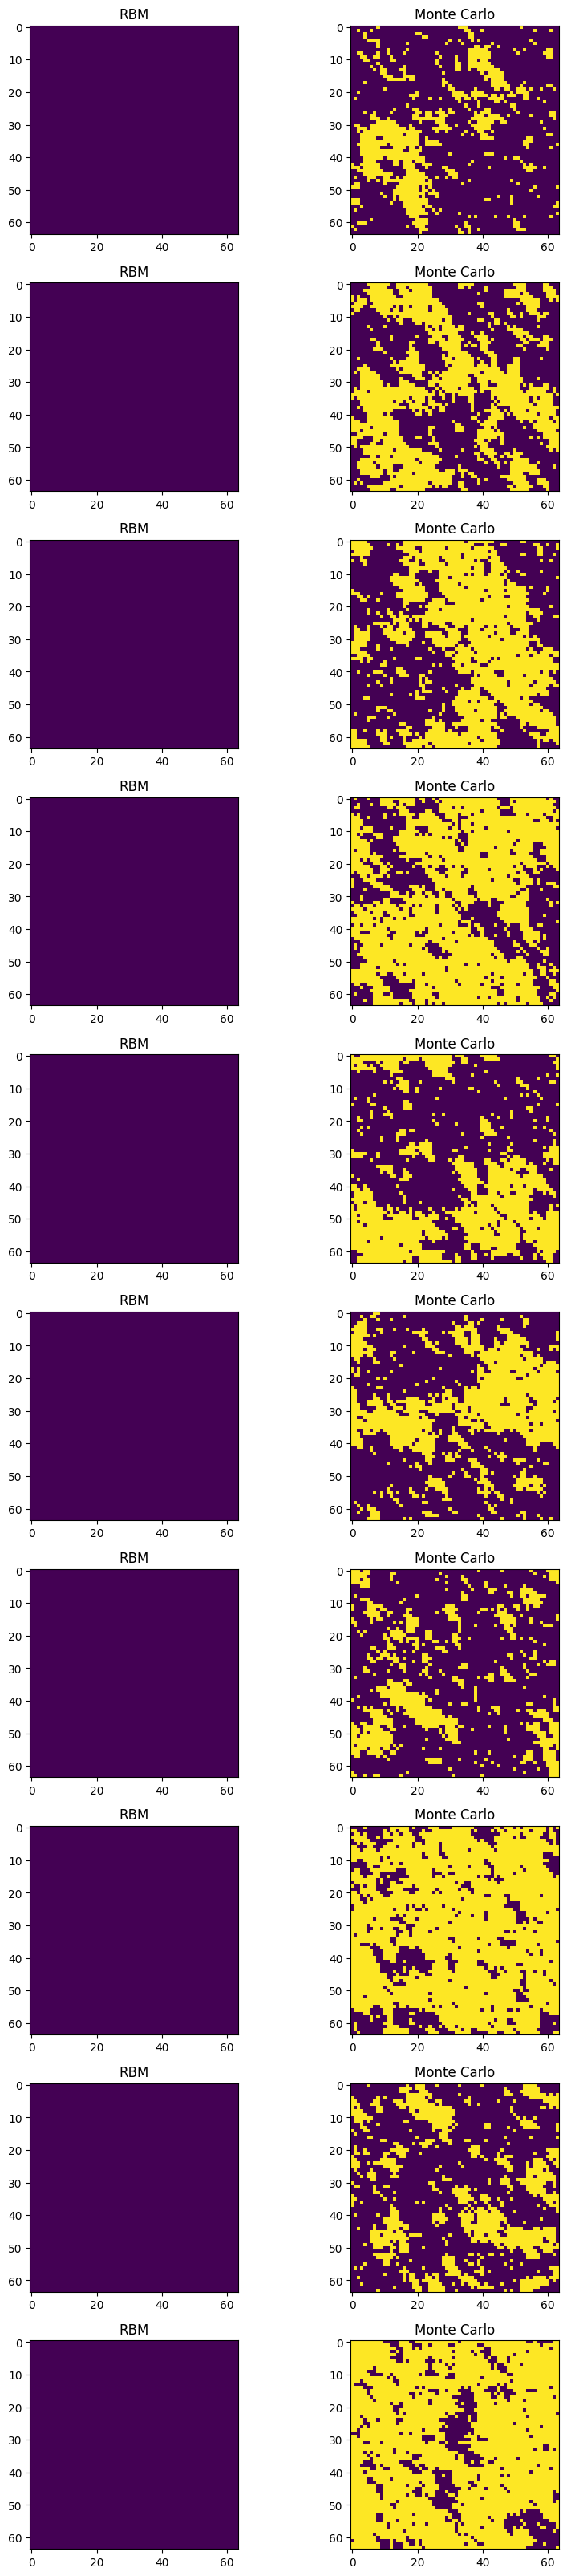

In [10]:
compare_plot(dataset[:10], data_generated)